# Cloning Content

## Introduction

The Python API team concluded we needed a guide for Cloning Content. We tackled the task to make the ultimate roadmap for how to get content from one Web GIS to another. First question to answer: What does it mean to `clone`? Merriam-Webster defines [`cloning`]() as _"propagat[ing] a clone from."_ (Didn't I hear my 2nd grade teacher - and every teacher after that for that matter - say it's unhelpful to use the word you are defining in its definition?...) So, diving into the definition of a _"clone"_ reads _"the aggregate of genetically identical cells or organisms asexually produced by or from a single progenitor cell or orgasm."_ Ok, not exactly the context we're working in when discussing a Web GIS. Further along the line we get to something more along the lines of what we're thinking: _"one that appears to be a copy of an original form."_ BINGO! 

Leveraging the Python API to clone content from one Web GIS to another can be thought of as _"propagating content that appears to be a copy of the original content."_. Given all the different content and item types, possible Enterprise configurations, potential ArcGIS Online Organization arrangements, security considerations, and item dependencies, just to name a few variables, `clone_items()` aims to _propagate_ an exact duplicate of one item with all its uses and functionality from an original portal to a second portal, but there may be circumstances, which can not all possibly be listed, predicted or defined, that lead the clone to come close but not quite produce an identical copy. In addition, the variety of means for publishing items creates varying possibilities for supported, related, or source items created during the publishing process. The relationship between any supported, related, or source items must be considered when cloning an item. For example, the overwrite functionality will not be available on cloned hosted feature layer items because they do not have a source document from which they were published. The FAQ [here](https://doc.arcgis.com/en/arcgis-online/reference/faq.htm#DELETE_SRC) provides important information regarding source items in ArcGIS Online. But...given our education on `cloning`, we now know that cloning an item produces a second item which **appears** - but may not be identical to the original. It's important to temper expectations when thinking about the Python API [`clone_items()`](https://developers.arcgis.com/python/api-reference/arcgis.gis.toc.html#arcgis.gis.ContentManager.clone_items) function. There may be times some items will not migrate as expected. 

When talking about cloning items, let's establish some basic terminology.  Cloning can refer to all kinds of transfer, from ArcGIS Enterprise to ArcGIS Online, Enterprise to Enterprise, or ArCGIS Online to Enterprise. (The GIS Community infrequently discusses the need to clone between two distinct ArcGIS Online Organiztions.) Rather than tangle ourselves up when trying to distinguish between these portal types while writing about them, we'll refer to the portal or organization where the content originates as the _source_ regardless of portal type. We'll consider the portal or organization to which we'll clone content as the _target_. Done.

This document illustrates the workflow of gathering source items using a source administrator account, and cloning them into a target administrator account.  This gaurantees the user account possesses all necessary privileges within the source to access the item and any dependencies and within the target to create the item and data. The target administrator subsequently can create user accounts and reassign item ownership and/or group membership according to need. This might also be the simplest workflow when the portal has users managed by an external identity store rather than using built-in accounts.

Any content in any portal must be owned by a [`user`](https://developers.arcgis.com/python/api-reference/arcgis.gis.toc.html#user), so at least one _user_ must exist in the target. If you don't plan on using the administrator accounts in a workflow such as this, you may want to investigate the [`Clone Portal users, groups and content`](../sample-notebooks/clone-portal-users-groups-and-content/#Copy-Users) sample notebook on how to define functions that can copy `user` and `group` objects and clone content in that manner. 

As originally written, Python API developers designed the `clone_items()` function for copying the following item types:
 * Hosted Web Applications built with Web AppBuilder or shared using Configurable App Templates
 * Web Maps
 * Hosted Feature Layers
 * Hosted Feature Layer Views
 * Feature Collections
 * Survey123 Forms
 * Workforce Projects
 * Story Maps
   * References to web maps and applications will not be cloned. The new story map will continue to point to the original maps and applications.
 * Operation Views
 * Dashboards
 * Feature Collections
 * Simple Types
   * Those items with a download, including file geodatabases, shapefiles, code samples, zip files, and packages amongst others

`clone_items()` clones the dependencies for the more complex items listed above. For example, cloning an existing web application, clones the web map and all hosted feature layers referenced in the map.

`clone_items()` will not clone map services and image services. Since these services can be published to servers other than the hosted server in a configuration, it's impossible for the function to determine where to publish them in the target. As a result, these items will copy over, but will continue to point back to the original source URL. 

Let's work through examples of cloning individual items and inspect the results.

We're going to clone a few different item types, starting with hosted feature layers and ending with more complex items that consume other items.

First, let's import the necessary libraries, and connect to our source and target GIS:

### Import libraries

In [132]:
from pathlib import Path
import sys

from arcgis.gis import GIS
from arcgis.env import active_gis
from arcgis.mapping import WebMap

### Connect to source and target portals

In [133]:
source = GIS(profile="your_ent_admin_profile", verify_cert=False)
#source = GIS(profile="your_online_admin_profile", verify_cert=False)
print(source)

GIS @ https://pythonapi.playground.esri.com/portal version:7.1


In [134]:
target = GIS(profile="cloning_admin", verify_cert=False)
#target = GIS(profile="your_online_admin_profile", verify_cert=False)
print(target)

GIS @ https://geosaurus.maps.arcgis.com version:8.1


Let's start from a discovery position as an administrator. We'll simulate an administrator who's been testing and developing using ArcGIS Online as a development environment who wants to clone user data into an on-premise Enterprise environment for further development.

#### Helper Function
Let's write a helper function to create a dictionary with the item type as the key, and a list of all the corresponding item types as the value.

In [135]:
def get_user_items(user, gis):
    user_inventory = {}
    user_items = gis.content.search(query=f"* AND owner:{user.username}", max_items=500)
    for item in user_items:
        if not item.type in user_inventory:
            user_inventory[item.type] = [i 
                                         for i in user_items 
                                         if i.type == item.type]
    return user_inventory

In [141]:
user_inventory = get_user_items(source.users.me, source)

In [142]:
user_inventory

{'Map Service': [<Item title:"Jordan" type:Map Image Layer owner:arcgispyapibot>,
  <Item title:"Toronto Greenspace and Community Housing" type:Map Image Layer owner:arcgispyapibot>],
 'Dashboard': [<Item title:"Kenya Conservation Efforts" type:Dashboard owner:arcgispyapibot>],
 'Feature Service': [<Item title:"Nairobi County Boundaries" type:Feature Layer Collection owner:arcgispyapibot>,
  <Item title:"agg_nola_yrly_svc_calls_to_block_groups" type:Feature Layer Collection owner:arcgispyapibot>,
  <Item title:"KEN_admin_boundaries" type:Feature Layer Collection owner:arcgispyapibot>,
  <Item title:"Botswana Power Plants" type:Feature Layer Collection owner:arcgispyapibot>,
  <Item title:"New_Orleans_Boundary_gax" type:Feature Layer Collection owner:arcgispyapibot>,
  <Item title:"Nairobi County Boundaries_vw" type:Feature Layer Collection owner:arcgispyapibot>,
  <Item title:"Kenya Wetlands" type:Feature Layer Collection owner:arcgispyapibot>,
  <Item title:"Kenya Protected Areas" typ

In [138]:
for itype, ilist in user_inventory.items():
    try:
        print(f"{itype}\n{'-'*50}")
        for i in ilist:
            print(f"{' ':3}{i.title:50}")
        print("\n")
    except Exception as e:
        print(f"\t\tOperation failed on: {i.title}")
        print(f"\t\tException: {sys.exc_info()[1]}")
        continue

Map Service
--------------------------------------------------
   Jordan                                            
   Toronto Greenspace and Community Housing          


Dashboard
--------------------------------------------------
   Kenya Conservation Efforts                        


Feature Service
--------------------------------------------------
   Nairobi County Boundaries                         
   agg_nola_yrly_svc_calls_to_block_groups           
   KEN_admin_boundaries                              
   Botswana Power Plants                             
   New_Orleans_Boundary_gax                          
   Nairobi County Boundaries_vw                      
   Kenya Wetlands                                    
   Kenya Protected Areas                             
   cpy_tods_nola_svc_calls                           
   airprtx0201                                       
   tlh_houshold_data_blkgrp                          
   wetlands_sum_within_county                    

### Suggested Cloning Order
Given the nature of dependencies in the Web GIS system and the fact the `clone_items()` function can use the `search_existing_items` parameter to ensure against repeated cloning, items that serve as the foundation for other items should be cloned first. In other words, work from the bottom up in terms of dependencies.  For example, a `Web Map` often contains multiple layers.  When cloning the Web Map, the software must first compile the definition of the Web Map, which cannot be completed until each Feature Layer definition within it is compiled. Then the software must clone each Feature Layer item before it clones the Web Map and wires it to the Feature Layers within the target. Instead, cloning the Feature Layer items first allows the `clone_items()` function to search through existing items and definitions and simply clone over the Web Map definitionn and and rewire it to read the target feature services which alread exist. This can save time.

We can return lists of specific item_types from our inventory.  First, let's print a list of the disctinct item types avaiable for this user:

In [ ]:
for item_type in list(user_inventory.keys()):
    print(item_type)

We can create a list of the hosted feature services using the `typeKeywords` property for items on our Feature Services:

### Feature Layers

In [ ]:
hosted_fsvc = [fs 
               for fs in user_inventory["Feature Service"]
               if 'Hosted Service' in fs.typeKeywords]

**Note:** This result includes `hosted feature layer views` created from hosted feature layers.  Use the `typeKeywords` `'View Service'` to isolate views.

In [ ]:
print(f"{'Feature Layer':<30}{'Folder ID':<35}{'Folder Name':15}{'Item ID'}\n"
      f"{'-'*28:<30}{'-'*33:<35}{'-'*13:<15}{'-'*37}")
for hosted_fs in hosted_fsvc:
    if not hosted_fs.ownerFolder:
        print(f"{hosted_fs.title[:28]:30}{' ':35}{'Root Folder':15}{hosted_fs.id}")
    else:
        print(f"{hosted_fs.title[:28]:30}{hosted_fs.ownerFolder:35}"
              f"""{next(f['title'] for f in source.users.me.folders 
                   if f['id'] == hosted_fs.ownerFolder):15}"""
              f"{hosted_fs.id}")

Let's run clone on this small set of hosted Feature Services, alloting for any failed cloning, and replicate the source folder structure as well.

In [ ]:
for hfs in hosted_fsvc:
    try:
        if hfs.ownerFolder:
            folder = next((f['title'] 
                          for f in source.users.me.folders 
                          if f['id'] == hfs.ownerFolder))
            if not folder in [fld['title']
                              for fld in target.users.me.folders]:
                target.content.create_folder(folder=folder)
            print(f"Cloning {hfs.title}...")
            target.content.clone_items([hfs], folder=folder)
            print(f"...completed")
        else:
            print(f"Cloning {hfs.title}...")
            target.content.clone_items([hfs])
            print(f"...completed")
    except Exception as e:
        print(f"...Failed to Clone {hfs.title}...")
        print(f"\tException Type: {sys.exc_info()[0]}")
        print(f"\tException Value: {sys.exc_info()[1]}")
        print(f"\tException Traceback line: {sys.exc_info()[2].tb_lineno}")
        print(f"\tException Traceback instruction: {sys.exc_info()[2].tb_lasti}")
        continue

Let's see run a query in our target to see what resulted.

In [ ]:
trg_inventory = get_user_items(target.users.me, target)

In [ ]:
for itype, ilist in trg_inventory.items():
    try:
        print(f"{itype}\n{'-'*50}")
        for i in ilist:
            print(f"{' ':3}{i.title:50}")
        print("\n")
    except Exception as e:
        print(f"\t\tOperation failed on: {i.title}")
        print(f"\t\tException: {sys.exc_info()[1]}")
        continue

In [ ]:
t_hosted_fsvc = [fs 
               for fs in trg_inventory["Feature Service"]
               if 'Hosted Service' in fs.typeKeywords]

In [ ]:
print(f"{'Feature Layer':<30}{'Folder ID':<35}{'Folder Name'}\n{'-'*28:<30}{'-'*33:<35}{'-'*15}")
for hosted_fs in t_hosted_fsvc:
    if not hosted_fs.ownerFolder:
        print(f"{hosted_fs.title[:28]:30}{' ':35}{'Root Folder'}")
    else:
        print(f"{hosted_fs.title[:28]:30}{hosted_fs.ownerFolder:35}"
              f"{next(f['title'] for f in target.users.me.folders if f['id'] == hosted_fs.ownerFolder)}")

### Web Maps

We can see all the same `Feature Layers` with new item ids in the same folders as the source organization.

Now, let's look at the `Web Maps` in our source organization and clone them to the target. We'll revisit the source administator's `get_user_inventory` results to examine the Web Maps:

In [ ]:
for wm in user_inventory['Web Map']:
    wm_obj = WebMap(wm)
    print(wm_obj.item.title)

Let's inspect what layers are in each Web Map.

In [ ]:
for wm in user_inventory['Web Map']:
    wm_obj = WebMap(wm)
    print(f"{wm_obj.item.title}\n{'-'*100}")
    for wm_layer in wm_obj.layers:
        try:
            print(f"{' '*2}{wm_layer['title']:40}{wm_layer['url'].split('/')[2]:35}{dict(wm_layer)['itemId']}")
        except:
            print(f"{' '*2}{wm_layer['title']:40}{wm_layer['url'].split('/')[2]:35}{wm_layer.id}")

In [ ]:
for wm in user_inventory['Web Map']:
    wm_obj = WebMap(wm)
    print(f"{wm_obj.item.title}\n{'-'*50}")
    if wm_obj.item.ownerFolder:
        folder_name = [f['title'] for f in source.users.me.folders 
                       if f['id'] == wm_obj.item.ownerFolder][0]
        try:
            print(f"...cloning {wm_obj.item.title}")
            target.content.clone_items(items=[wm_obj.item], 
                                       folder=folder_name)           
            print(f"...completed")
        except Exception as e:
            print(f"....failed to clone {wm_obj.item.title}")
            print(str(e))

In [ ]:
target.content.search("* AND owner:clonerator", item_type="Web Map")

In [ ]:
target_inventory = get_user_items(target.users.me, target)

In [ ]:
target_inventory

In [ ]:
for wm in target_inventory['Web Map']:
    wm_obj = WebMap(wm)
    print(f"{wm_obj.item.title}\n{'-'*100}")
    for wm_layer in wm_obj.layers:
        try:
            print(f"{' '*2}{wm_layer['title']:40}{wm_layer['url'].split('/')[2]:35}{dict(wm_layer)['itemId']}")
        except:
            print(f"{' '*2}{wm_layer['title']:40}{wm_layer['url'].split('/')[2]:35}{wm_layer.id}")
    print("\n")

### Operations Dashboards

<Item title:"Kenya Conservation Efforts" type:Dashboard owner:arcgispyapibot>
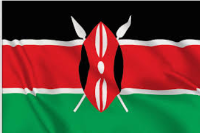

In [143]:
ops_dash = user_inventory['Dashboard'][0]
ops_dash

<Item title:"KEN_Administrative_Boundaries" type:Web Map owner:arcgispyapibot>
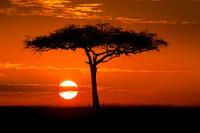

In [149]:
for dash_widget in ops_dash.get_data()['widgets']:
    if dash_widget['type'] == 'mapWidget':
        dash_webmap = source.content.get(dash_widget['itemId'])
dash_webmap

In [ ]:
dash_webmap

### Story Maps

#### ArcGIS StoryMaps
Released in July 2019, [`ArcGIS StoryMaps`](https://www.esri.com/en-us/arcgis/products/arcgis-storymaps/overview) are the next generation of storytelling with maps. Get the full scoop on why this new format [here](https://storymaps.arcgis.com/stories/0d565f8fb4874e4fb44c6cb7276c78fb)!

Let's connect to our GIS to take a look

In [ ]:
sm_source = GIS(profile="cloning_admin")
sm_target = GIS(profile="esrihax")

In [ ]:
storymap = sm_source.content.search("Conservation*", item_type="StoryMap")[0]
storymap

In [ ]:
for node, block in storymap.get_data()['nodes'].items():
    if block['type'] == 'webmap':
        sm_webmap = sm_source.content.get(block['data']['map'][2:])
sm_webmap

In [ ]:
wm_obj = WebMap(sm_webmap)
print(f"{wm_obj.item.title}\n{'-'*115}")
for wm_layer in wm_obj.layers:
    try:
        wm_layer_item = sm_source.content.get(dict(wm_layer)['itemId'])
        if "Hosted Service" in wm_layer_item.typeKeywords:
            print(f"{' '*2}{wm_layer['title']:30}{wm_layer['url'].split('/')[2]:33}"
                  f"{sm_source.content.get(dict(wm_layer)['itemId']).type.upper():18}"
                  f"{dict(wm_layer)['itemId']}")
        else:
            print(f"{' '*2}{wm_layer['title']:30}{wm_layer['url'].split('/')[2]:33}"
                  f"{sm_source.content.get(dict(wm_layer)['itemId']).type:18}"
                  f"{dict(wm_layer)['itemId']}")
            
    except:
        print(f"{' '*2}{wm_layer['title']:30}{wm_layer['url'].split('/')[2]:35}{wm_layer.id}")

In [ ]:
sm_target.content.clone_items(items=[storymap])

In [ ]:
sm_target_inventory = get_user_items(sm_target.users.me, sm_target)

In [ ]:
cloned_sm = sm_target_inventory['StoryMap'][0]
cloned_sm

In [ ]:
for node, block in cloned_sm.get_data()['nodes'].items():
    if block['type'] == 'webmap':
        cloned_sm_webmap = sm_target.content.get(block['data']['map'][2:])
cloned_sm_webmap

In [ ]:
wm_obj = WebMap(cloned_sm_webmap)
print(f"{wm_obj.item.title}\n{'-'*115}")
for wm_layer in wm_obj.layers:
    try:
        wm_layer_item = sm_target.content.get(dict(wm_layer)['itemId'])
        if "Hosted Service" in wm_layer_item.typeKeywords:
            print(f"{' '*2}{wm_layer['title']:30}{wm_layer['url'].split('/')[2]:33}"
                  f"{sm_target.content.get(dict(wm_layer)['itemId']).type.upper():18}"
                  f"{dict(wm_layer)['itemId']}")
        else:
            print(f"{' '*2}{wm_layer['title']:30}{wm_layer['url'].split('/')[2]:33}"
                  f"{sm_target.content.get(dict(wm_layer)['itemId']).type:18}"
                  f"{dict(wm_layer)['itemId']}")
            
    except:
        print(f"{' '*2}{wm_layer['title']:30}{wm_layer['url'].split('/')[2]:35}{wm_layer.id}")

#### Classic Story Maps
Classic story maps are stored in the portals as `Web Mapping Application` items.

In [ ]:
wma = user_inventory['Web Mapping Application'][0]
wma

In [ ]:
wma_webmap = source.content.get(wma.get_data()['values']['webmap'])
wma_webmap

In [ ]:
wm_obj = WebMap(wma_webmap)
print(f"{wm_obj.item.title}\n{'-'*115}")
for wm_layer in wm_obj.layers:
    try:
        wm_layer_item = source.content.get(dict(wm_layer)['itemId'])
        if "Hosted Service" in wm_layer_item.typeKeywords:
            print(f"{' '*2}{wm_layer['title']:30}{wm_layer['url'].split('/')[2]:33}"
                  f"{source.content.get(dict(wm_layer)['itemId']).type.upper():18}"
                  f"{dict(wm_layer)['itemId']}")
        else:
            print(f"{' '*2}{wm_layer['title']:30}{wm_layer['url'].split('/')[2]:33}"
                  f"{source.content.get(dict(wm_layer)['itemId']).type:18}"
                  f"{dict(wm_layer)['itemId']}")
            
    except:
        print(f"{' '*2}{wm_layer['title']:30}{wm_layer['url'].split('/')[2]:35}{wm_layer.id}")

The original [`Web Map`](https://developers.arcgis.com/python/api-reference/arcgis.mapping.html#webmap) contained 3 layers from a `hosted Feature Layer` in the `Web GIS` as the web map, and 2 `Feature Layers` items sourced from am ArcGIS Online Feature Service. Let's inspect the result to see what happens with the `clone_items()` function and accepting the default values for the `copy_data` and `search_existing_items` parameters - both `True`.

In [ ]:
target.content.clone_items(items=[wma],
                           folder="Africa_Storymap")

We can see that cloning output of the `Web Mapping Application` lists the application, the `Web Map` configured with the application, and the `Feature Layer Collection` layers consumed in the Web Map. As mentioned before, the original web map consumed 3 layers from a hosted feature service, and 2 feature layer items referencing ArcGIS Online layers.

Let's examine the cloned application, web map, and layers to examine the results.

First we'll get the inventory of items now owned by the user we're logged into the target Web GIS as:

In [ ]:
target_inventory = get_user_items(target.users.me, target)

In [ ]:
for itype, ilist in target_inventory.items():
    try:
        print(f"{itype}\n{'-'*50}")
        for i in ilist:
            print(f"{' ':3}{i.title:50}")
        print("\n")
    except Exception as e:
        print(f"\t\tOperation failed on: {i.title}")
        print(f"\t\tException: {sys.exc_info()[1]}")
        continue

In [ ]:
cloned_wma = target_inventory['Web Mapping Application'][0]
cloned_wma

In [ ]:
cloned_wma_webmap = target.content.get(cloned_wma.get_data()['values']['webmap'])
cloned_wma_webmap

In [ ]:
wm_obj = WebMap(cloned_wma_webmap)
print(f"{wm_obj.item.title}\n{'-'*115}")
for wm_layer in wm_obj.layers:
    try:
        wm_layer_item = target.content.get(dict(wm_layer)['itemId'])
        if "Hosted Service" in wm_layer_item.typeKeywords:
            print(f"{' '*2}{wm_layer['title']:30}{wm_layer['url'].split('/')[2]:33}"
                  f"{target.content.get(dict(wm_layer)['itemId']).type.upper():18}"
                  f"{dict(wm_layer)['itemId']}")
        else:
            print(f"{' '*2}{wm_layer['title']:30}{wm_layer['url'].split('/')[2]:33}"
                  f"{target.content.get(dict(wm_layer)['itemId']).type:18}"
                  f"{dict(wm_layer)['itemId']}")
            
    except:
        print(f"{' '*2}{wm_layer['title']:30}{wm_layer['url'].split('/')[2]:35}{wm_layer.id}")

We see that `clone_items()` cloned the feature service containing the layers the web map consumed and created a new hosted feature service in the target (evidenced by the `item id` above), the web map used to configure the web mapping application, and the web mapping application itself. It also cloned the `feature layer` items in the web map, but did not clone them `feature layer` items in the organization, so they do not as of yet have `item ids` in the organization.

### One-offs

In [ ]:
dsdev = GIS(profile="dev81", verify_cert=False)

In [ ]:
ds_clone = dsdev.content.clone_items(items=user_inventory['Web Map'][0],
                                     folder="Africa_StoryMap"

Next, let's use our helper function to get an inventory of another user's items:

In [ ]:
new_user = source.users.search(query="jy*geosaurus")[0]
new_user

In [ ]:
user_item_inventory = item_inventory(new_user.username)

In [ ]:
user_item_inventory

In [ ]:
def get_all_items(portal_user):
    gis = active_gis
    user = gis.users.search("username:" + portal_user)[0]
    items = {"root": [i for i in user.items()]}    
    if user.folders and [f for f in user.folders if user.items(folder=f)]:
        for folder in user.folders:
            if user.items(folder=folder):
                folder_items = [i for i in user.items(folder=folder)]
            items[folder['title']] = folder_items
    return items

In [ ]:
def owns_items(username):
    gis = active_gis
    portal_user = gis.users.search("username:"+username)[0]
    if portal_user.items():
        return True
    else:
        if (portal_user.folders and 
            [f 
             for f in portal_user.folders 
             if portal_user.items(folder=f)]):
            return True
        else:
            return False

In [ ]:
item_owners = [u 
               for u in active_gis.users.search("NOT username:esri_*")
               if owns_items(u.username)]
item_owners

In [ ]:
org_types = []
for user in item_owners:
    try:
        type_set = {item.type
                    for folder, item_list in get_all_items(user.username).items()
                    for item in item_list}
        for t in type_set:
            if not t in org_types:
                org_types.append(t)
    except Exception as e:
        print(f"Cannot process user {user.username}")

## Item Relationship and cloning

In [ ]:
len(org_types)

In [ ]:
if len(org_types) % 2 > 0:
    for a,b in zip(org_types[0::2], org_types[1::2]):
        print(f"{a:25}{b:25}")
        print(f"{org_types[-1]:25}")
else:
    for a,b in zip(org_types[0::2], org_types[1::2]):
        print(f"{a:25}{b:25}")      

In [ ]:
def get_item_types(username, item_type):
        item_list = [item
                     for folder,item_list in get_all_items(username).items()
                     for item in item_list
                     if item.type.lower() == item_type.lower()]
        if item_type.lower() in ['feature service', 'vector tile service',
                        'image service', 'scene service', 'map service']:
            non_hosted = [i 
                          for i in item_list
                          if not 'Hosted Service' in i.typeKeywords]
            hosted = [h 
                      for h in item_list
                      if 'Hosted Service' in h.typeKeywords]
            return {"hosted_" + item_type.lower().replace(' ','_'):hosted, 
                    "non_hosted_"+item_type.lower().replace(' ','_'):non_hosted}
        else:
            return {item_type.lower().replace(' ','_'):item_list}

In [ ]:
hosted, non_hosted = get_item_types('ent_admin', 'feature service').items()

In [ ]:
non_hosted_fs = non_hosted[1]

In [ ]:
hosted_fs = hosted[1]

In [ ]:
for fs_item in hosted_fs:
    try:
        if fs_item.related_items('Service2Data', 'forward'):
            rel_items = fs_item.related_items('Service2Data', 'forward')
            for item in rel_items:
                print(f"{fs_item.title}\n{'-'*50}\n\t{item.title[:38]:40}{item.type}")
        else:
            print(f"{fs_item.title}\n{'-'*50}\n\tNo related items")
    except Exception as e:
        print(f"{fs_item.title}\n{'-'*50}\n\t{str(e)}")

In [ ]:
emb_item = hosted_fs[4]

In [ ]:
result_items = ent.content.clone_items(items=[emb_item],
                                       folder="cloned_from_ent",
                                       search_existing_items=False)

In [ ]:
result_items

In [ ]:
result_items[0].related_items("Service2Data", "forward")

In [ ]:
emb_item.related_items("Service2Data", "forward")

In [ ]:
emb_item.export(title="foreign_embassies_us",
               export_format="CSV")

In [ ]:
for map_service in non_hosted[1]:
    print(f"{map_service}\n{'-'*90}")
    print(f"{map_service['title']:45}{map_service['type']:20}{map_service.id}")
    print(f"{' ':4}Service Name: {Path(map_service.url).parts[-2]}")
    if map_service.related_items('Service2Service', 'forward'):
        ms_sd = map_service.related_items('Service2Service', 'forward')[0]
        print(f"{' ':2}{ms_sd.title:45}{ms_sd.type:20}{ms_sd.id}")
    else:
       print(f"{' ':4}{map_service.title} has {len(map_service.dependent_to()['list'])} items depending on it")
       print(f"{' ':4}{map_service.title} is dependent upon {len(map_service.dependent_upon()['list'])} items")
       for item in map_service.dependent_upon()['list']:
             print(f"{' ':8}{item['dependencyType']:12}{item['id']}")
    print("\n")

In [ ]:
for server in target.admin.federation.servers['servers']:
    if not server['serverRole'] == 'FEDERATED_SERVER':
        print(f"{server['url']:50}{server['serverRole']:20}{server['id']}")
    else:
        print(f"{server['url']:50}{server['serverFunction'].upper():20}{server['id']}")     

### Advanced Search

In [ ]:
sd_fs_name = "Toronto"
user = source.users.me.username

In [ ]:
for item in source.content.advanced_search(query=f"title:{sd_fs_name} AND owner:{user}")['results']:
    print(f"{item.title:25}{item.id:35}{item.type}")

In [ ]:
for folder, items in get_all_items('arcgis_python').items():
    print(f"{folder}\n{'-'*50}")
    hosted = [i for 
              i in items 
              if "Hosted Service" in i.typeKeywords]
    non_hosted = [i 
                  for i in items 
                  if not "Hosted Service" in i.typeKeywords and
                 "Service" in i.typeKeywords]
    others = [i
             for i in items
             if not "Service" in i.typeKeywords]
    if hosted:
          print(f"{' ':2}Hosted Items\n{'-'*50}")
          for h in hosted:
                print(f"\t{h.title[:40]:45}{h.type:30}{h.id}")
          else:
                pass
    print("\n")
    if non_hosted:
          print(f"{' ':2}Non Hosted Items\n{'-'*50}")
          for nh in non_hosted:
                print(f"\t{nh.title[:40]:45}{nh.type:30}{nh.id}")
          else:
                pass
    print("\n")
    if others:
          print(f"{' ':2}Non Service Items\n{'-'*50}")
          for o in others:
                print(f"\t{o.title[:40]:45}{o.type:30}{o.id}")

In [ ]:
get_item_types('arcgis_python', 'web map')

In [ ]:
active_gis

In [ ]:
source_org_id = source.properties['user']['orgId']
geo_org_id = geo.properties['user']['orgId']

In [ ]:
active_gis = geo

In [ ]:
print(f"Web Maps\n{'-'*50}")
for item_type,map_list in get_item_types('arcgis_python', 'web map').items():
    for web_map_item in map_list:
        print(f"{' ':2}{web_map_item.title[:55]:60}{web_map_item.id}\n{'='*25}")
        wm_obj = WebMap(web_map_item)
        if not wm_obj.layers:
            print(f"{' ':4}-has no layers")
        else:
            for wm_lyr in wm_obj.layers:
                if not wm_lyr.get('url'):
                    print(f"{' ':4}{wm_lyr['title'][:40]:45}No url for layer")
                else:
                    if Path(wm_lyr['url']).parts[2] == geo_org_id:
                        print(f"{' ':4}{wm_lyr['title'][:48]:50}"
                              f"{wm_lyr['layerType']:25}Hosted")
                    else:
                        print(f"{' ':4}{wm_lyr['title'][:48]:50}"
                              f"{wm_lyr['layerType']:30}Referenced")
        print("\n")

In [ ]:
wm0 = geo.content.get("e11ea9d9356d489fbac333a32e02e350")

In [ ]:
cloned_items = target.content.clone_items(items=[wm0],
                          folder="cloned_from_geos_no_urls",
                          search_existing_items=False)

In [ ]:
cloned_items[0]['isOrgItem']

In [ ]:
for lyr in set2_tpk_SD_map_svc.layers:
    print(f"{lyr.properties.name:50}") 

In [ ]:
for org_user in item_owners[0:2]:
    print(f"{org_user.username}\n{'-'*50}")
    for org_type in org_types:
          user_items = get_item_types(org_user.username, org_type)
          if user_items and org_type.lower() == "feature service":
              if not user_items["hosted_" + org_type.lower().replace(' ', '_')]:
                  pass
              else:
                  print(f"\tHosted Feature Services")
                  for fs_item in user_items["hosted_" + org_type.lower().replace(' ', '_')]:
                      print(f"\t\t{fs_item.title}")
              if not user_items["non_hosted_" + org_type.lower().replace(' ', '_')]:
                  pass
              else:
                  print(f"\tReferenced Feature Services")
                  for rfs_item in user_items["non_hosted_" + org_type.lower().replace(' ', '_')]:
                      print(f"\t\t{rfs_item.title[:35]:40}{Path(rfs_item.url).parts[1]}")
          else:
              if user_items[org_type.lower().replace(' ', '_')]:
                  print(f"\t{org_type}")
                  for item in user_items[org_type.lower().replace(' ','_')]:
                      print(f"\t\t{item.title}")
    print("\n")

In [ ]:
geo.properties['user']['orgId']

In [ ]:
item = source.content.search("*")[0]

In [ ]:
target.groups.search("*")[0].categories